In [2]:
# load Python modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from plot_helpers import generate_pdf_panel
from plot_helpers import plot_pdf
from plot_helpers import plot_pdf_and_cdf

In [29]:
N = 10   # number of samples
n = 30   # sample size

# generate N samples from (U_1,U_2,...,U_n)
usamples = {}
for i in range(0, N):
    column_name = "sample" + str(i)
    usamples[column_name] = rvU.rvs(n)

# usamples

In the last line we converted the dictionary `usamples` to a Pandas data frame `usamples_df`,
which will make plotting easier.


In [ ]:
# convert usamples to a Pandas data frame
usamples_df = pd.DataFrame(usamples)
usamples_df.shape
# usamples_df

(30, 10)

To obtain a strip plot of all the samples,
we can simply call the Seaborn function `stripplot` on the data frame `usamples_df`.

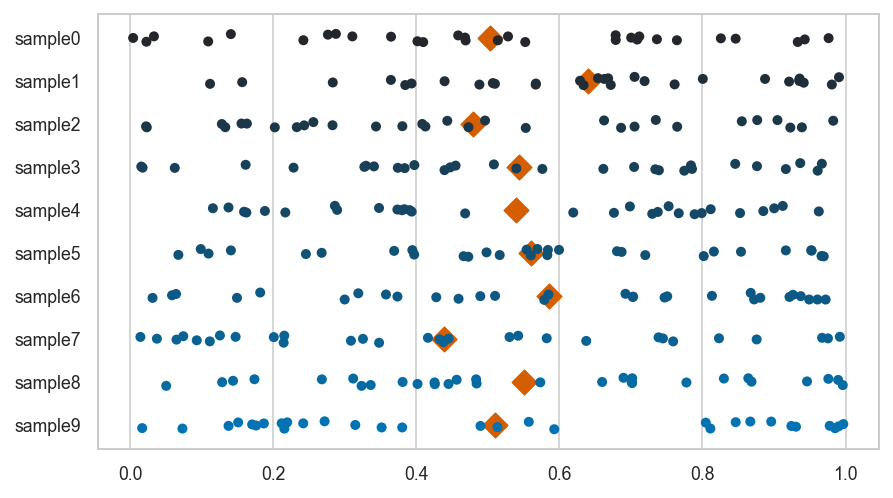

In [31]:
# generate strip plot
ax = sns.stripplot(usamples_df, orient="h", palette="dark:b")

# add diamond-shaped marker to indicate mean in each sample
for i in range(0, N):
    column_name = "sample" + str(i)
    ubar_i = usamples_df[column_name].mean()
    ax.scatter(ubar_i, i, marker="D", s=75, color="r")

In [24]:
from scipy.stats import t as tdist
df = 7
rvT = tdist(df=73)

tbars = gen_sampling_dist(rvT, statfunc=mean, N=1000, n=30)
tbars[0:10]

[0.2546629162847764,
 -0.052805898240538746,
 0.10989680612229603,
 -0.1252411111148421,
 -0.30134098448585095,
 0.18245499973804416,
 -0.3919513998786795,
 -0.21461552521963348,
 -0.2140129421919345,
 0.20552369335691717]

<AxesSubplot:ylabel='Count'>

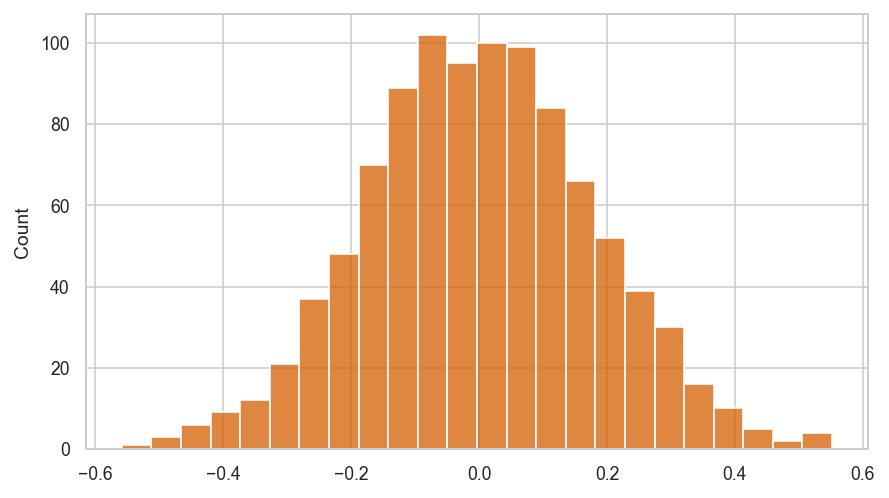

In [25]:
sns.histplot(tbars, color="r")

<AxesSubplot:>

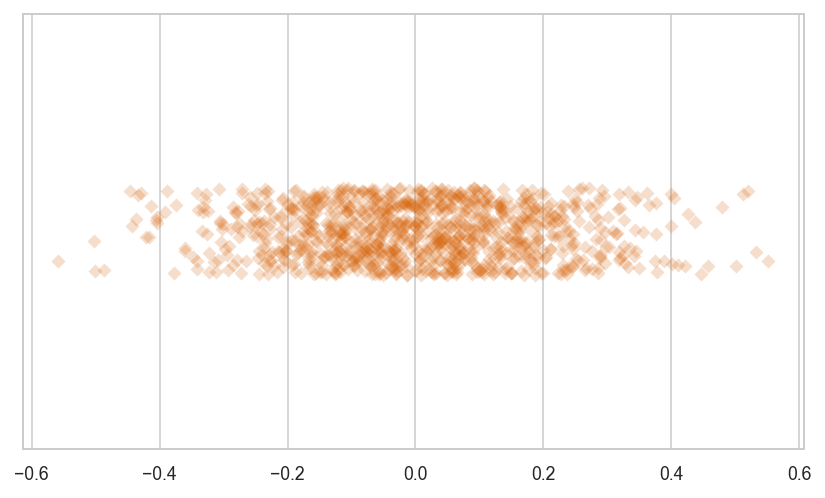

In [26]:
sns.stripplot(x=tbars, marker="D", alpha=0.2, color="r")

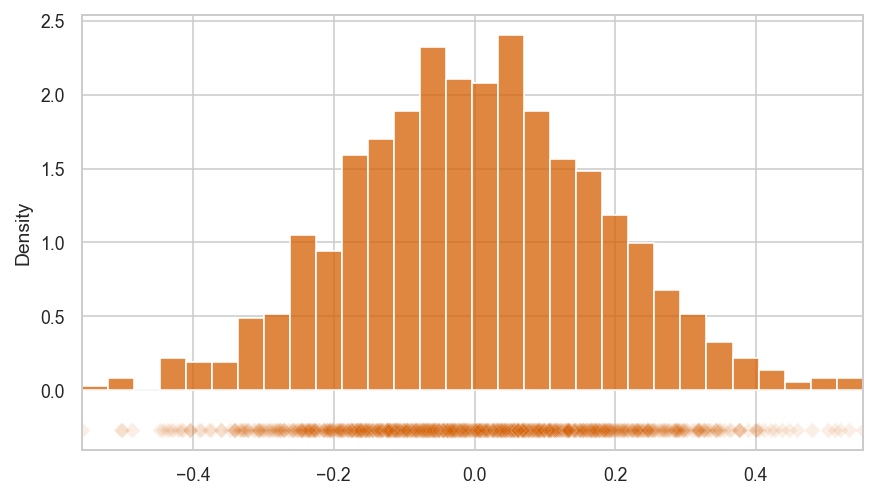

In [27]:
plot_sampling_dist(tbars)

Repeat S insights: for loop + histogram of obs from $f_X$ from any r.v. allows you to see visualize any stats procedure


<AxesSubplot:ylabel='Density'>

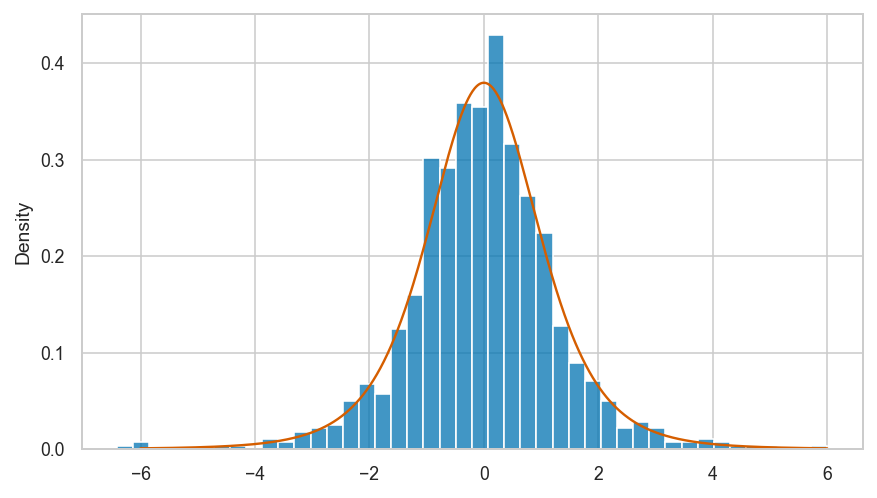

In [93]:
# demo t-dist
from scipy.stats import t as tdist
rvT = tdist(df=5)
tdata =rvT.rvs(1000)
sns.histplot(tdata, stat="density")
ts = np.linspace(-6,6,1000)
sns.lineplot(x=ts, y=rvT.pdf(ts), color="r")

<AxesSubplot:>

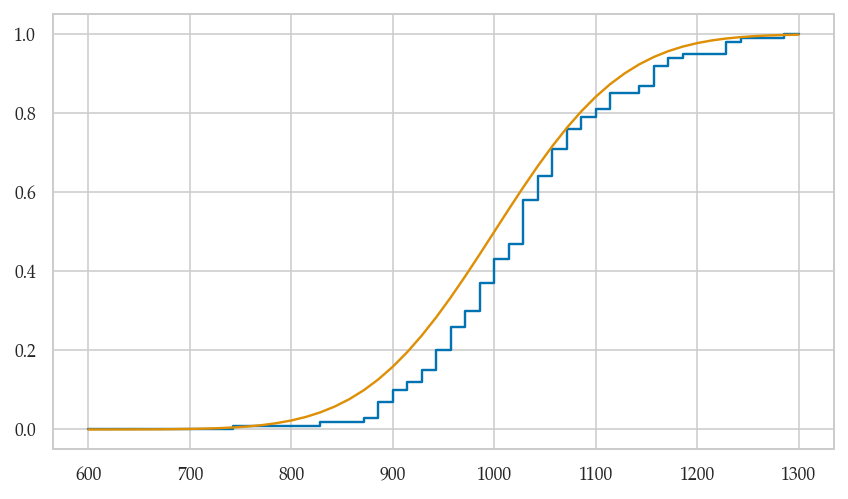

In [6]:
# Bonus: try playing with parameter n
from scipy.stats import norm
rvN = norm(1000,100)

def ecdf(data,b):
    return sum(data <= b) / len(data)

n = 100  # CHANGE ME: what is eCDF when n=10? ; when n=1000?
ndata = rvN.rvs(n)
bs = np.linspace(600,1300)
empFbs = [ecdf(ndata,b) for b in bs]
sns.lineplot(x=bs, y=empFbs, drawstyle='steps-post')

sns.lineplot(x=bs, y=rvN.cdf(bs))

#### Example 2: generating observations from the geometric distribution

Suppose we want to generate random observations
from the geometrically distributed random variable $G \sim \textrm{Geom}(p=0.2)$,
which corresponds to the waiting time until first success
in repeated sequence of Bernoulli trials,
where each trials has probability $p=0.2$ of success.

The function `gen_g` defined below is a generator of observations from the random variable $G$.

In [100]:
from scipy.stats import geom
rvG = geom(p=0.2)

def gen_g(p):
    u = random.random()
    for k in range(1, 100):
        if u <= rvG.cdf(k):
            return k


To generate a random observation from $B \sim \textrm{Bernoulli}(p=0.3)$,
we simply need to call the function `gen_b` with the keyword argument `p=0.3`.

In [103]:
gen_g(p=0.2)

2

Let's now generates `n=1000` observations from $G \sim \textrm{Geom}(p=0.2)$.

<AxesSubplot:ylabel='Count'>

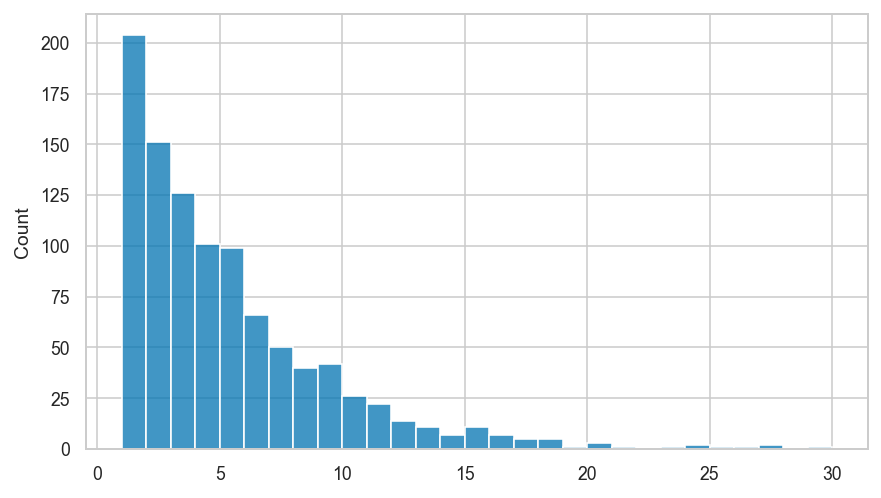

In [104]:
n = 1000
gsample = [gen_g(p=0.2) for i in range(0,n)]

sns.histplot(gsample)

#### Annotations on plot

Text(0.1, 0.5, 'Saturday\nMean')

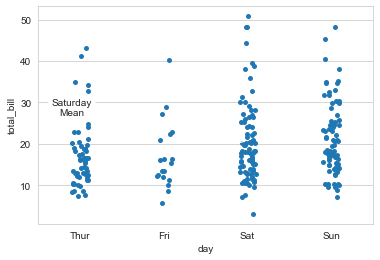

In [1]:
import seaborn as sns

sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
sat_mean = tips.loc[tips['day'] == 'Sat']['total_bill'].mean()

ax = sns.stripplot(x="day", y="total_bill", data=tips)
ax.annotate("Saturday\nMean",
            xy=(2, sat_mean), xycoords='data',
            xytext=(.1, .5), textcoords='axes fraction',
            horizontalalignment="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            bbox=dict(boxstyle="round", fc="w"),
            )

In [1]:
def variance(sample):
    """
    Compute the sample variance of the values in `sample`.
    """
    n = len(sample)
    xbar = mean(sample)
    sqdevs = [(x-xbar)**2 for x in sample]
    return sum(sqdevs) / (n-1)


In [22]:
def get_sampling_dist(rv, statfunc, n, N=1000):
    """
    Approximate the sampling distribution of the statistic `statfunc`
    for i.i.d. random samples of size `n` from the random variable `rv`.
    Draw `N` random samples and calculate `statfunc(sample)` for each.
    """
    sampling_dist = []
    for i in range(0, N):
        sample = rv.rvs(n)
        value = statfunc(sample)
        sampling_dist.append(value)
    return sampling_dist


### Example 1: Samples from a uniform distribution


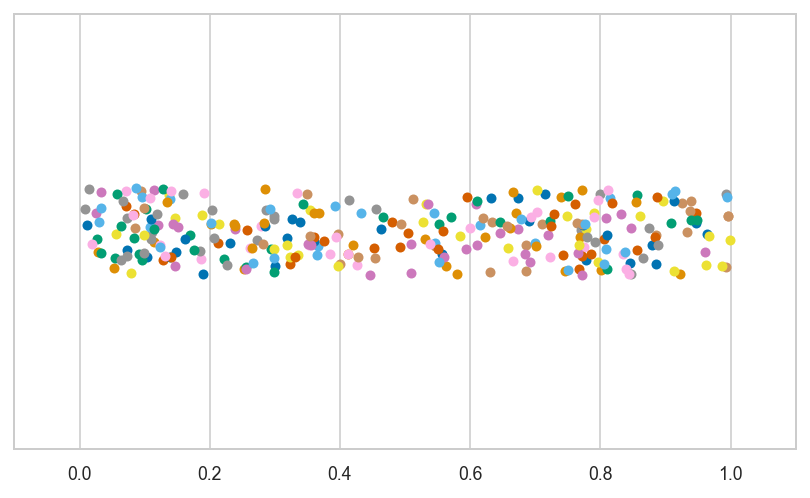

In [23]:
from scipy.stats import uniform

# define a uniform random variable
rv1 = uniform(0, 1)
mu1 = rv1.mean()    # 𝜇1 (mu)
sigma1 = rv1.std()  # 𝜎1 (sigma)

# plot data from 30 samples of size 10
N = 30
n = 10
plt.xlim(-0.1, 1.1)
for i in range(0, N):
    sample1 = rv1.rvs(n)
    sns.stripplot(x=sample1)

#### Sampling distribution of the mean

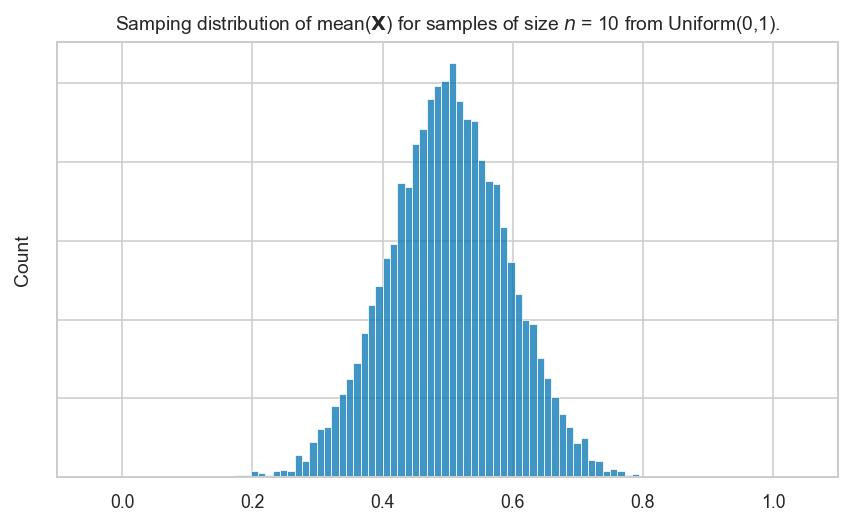

In [24]:
# compute the sampling distribution for samples of size n
mean_sdist_data1 = get_sampling_dist(rv1, mean, n, N=10000)

# plot a histogram of the sampling distribution
plt.xlim(-0.1, 1.1)
ax = sns.histplot(mean_sdist_data1, kde=False)
# stat="density"
ax.set(yticklabels=[])
_ = ax.set_title("Samping distribution of mean($\mathbf{X}$) for samples "
                 "of size $n$ = " + str(n) + ' from Uniform(0,1).')

In [25]:
xbar_mu = np.mean(mean_sdist_data1)
xbar_std = np.std(mean_sdist_data1, ddof=1)
print("The sampling distribution has mean", round(xbar_mu,2),
      "\nand the standard error is", round(xbar_std,5))

The sampling distribution has mean 0.5 
and the standard error is 0.09145


In [26]:
# CLT prediction about standard error: 
sigma1/np.sqrt(n)

0.09128709291752768

### Example 2: Samples from a normal distribution

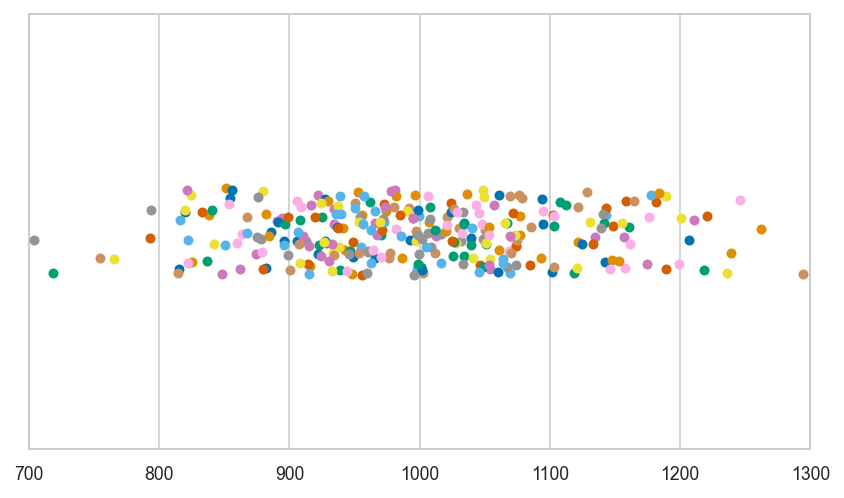

In [27]:
from scipy.stats import norm

# define a normal random variable
mu2 = 1000         # 𝜇2 (mu)
sigma2 = 100       # 𝜎2 (sigma)
rv2 = norm(mu2, sigma2)

# plot data from 30 samples of size 10
N = 30
n = 10
plt.xlim(700,1300)
for i in range(0, N):
    sample2 = rv2.rvs(n)
    sns.stripplot(x=sample2)

#### Sampling distribution of the mean

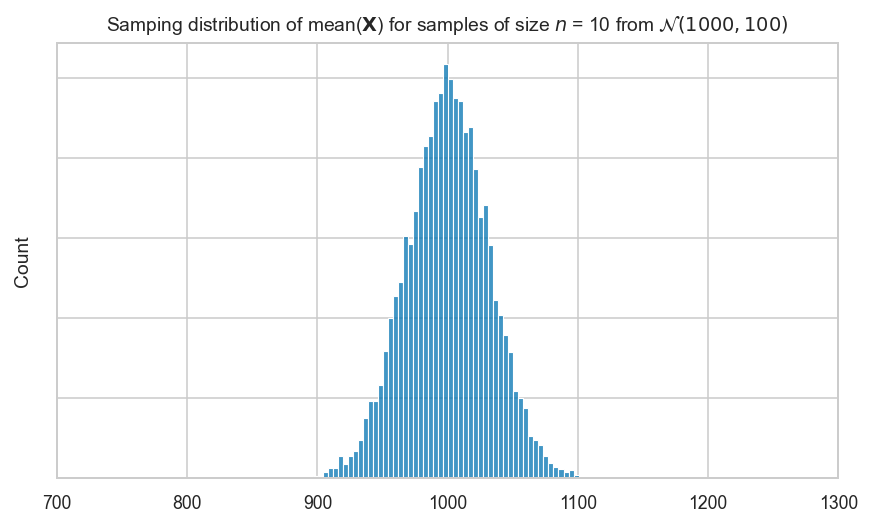

In [28]:
# compute the sampling distribution for samples of size n
mean_sdist_data2 = get_sampling_dist(rv2, mean, n, N=10000)

# plot a histogram of the sampling distribution
ax = sns.histplot(mean_sdist_data2, kde=False)
ax.set(yticklabels=[])
plt.xlim(700,1300)
_ = ax.set_title("Samping distribution of mean($\mathbf{X}$) for samples of size "
                 "$n$ = " + str(n) + ' from $\mathcal{N}('+ str(mu2) + ',' + str(sigma2) + ')$')

In [29]:
xbar_mu = np.mean(mean_sdist_data2)
xbar_std = np.std(mean_sdist_data2, ddof=1)
print("The sampling distribution has mean", round(xbar_mu,2),
      "\nand the standard error is", round(xbar_std,2))

The sampling distribution has mean 1000.02 
and the standard error is 31.47


In [30]:
# CLT prediction about standard error:
sigma2/np.sqrt(n)

31.622776601683793

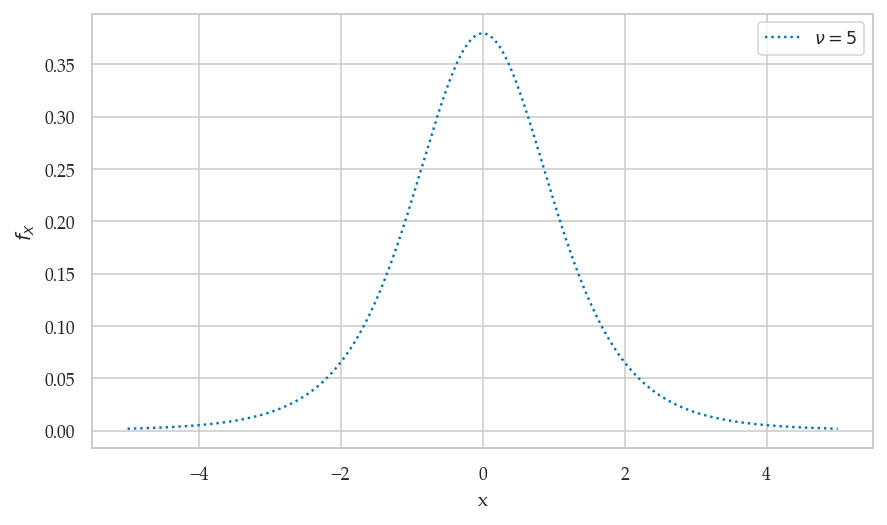

In [3]:
from scipy.stats import t


fig, ax = plt.subplots()
# for df in [2,5,10,100]:
df = 5
rvT = t(df)

xmin, xmax = [-5,5]
xs = np.linspace(xmin, xmax, 1000)
fXs = rvT.pdf(xs)
# sns.lineplot(x=xs, y=fXs, ax=ax, linestyle='--', label="lkj")
ax = plot_pdf(rvT, xlims=[-5,5], ax=ax, label="$\\nu={}$".format(df), linestyle=":")


In [ ]:
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

fig, ax = plt.subplots(1, 1)

CS = ax.contour(X, Y, Z, 6, colors='k')
ax.clabel(CS, fontsize=9, inline=True)
ax.set_title('Default negative contours')

In [ ]:
# # stats
# mean, var, skew, kurt = rvF.stats(moments='mvsk')
# mean, var, skew, kurt


### Why do we need probability theory in statistics?

Probability theory provides us with some essential tools needed for statistics:
  - modelling: describe a population as a probability distribution
  - sampling distributions: distributions obtained for random samples from a population

Additionally, artificially introduced randomness is the basis for two of the most important statistics "kung fu" techniques:

- **random selection** = if you collect a sample of size n randomly selected from a population, then compute statistics from the sample, you can then make inferences about the whole population.
- **random assignment** = create two roughly equivalent groups by randomly assigning participants into group A or group B. This random split is the basis for a statistical experiment that compares an intervention group and a control group. Given the participants were randomly assigned to the two groups, we can hope they are roughly equally distributed on all dimensions (similar distribution of all confounding variables), so that any differences observed between groups can be attributed to the intervention. Calculating the difference statistic intervention-control give an estimate of the effect size of this intervention.

# CUT MATERIAL from 21_prob_theory.ipynb

In [ ]:
# load Python modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Figures setup
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc={'figure.figsize': (7,4)},
)

%config InlineBackend.figure_format = 'retina'

# # silence annoying warnings
# import warnings; warnings.filterwarnings('ignore')

In [ ]:
# set random seed for repeatability
np.random.seed(42)

### Computing prob integrals using quad

#### Uniform

In [ ]:
def fU(u):
    if 0 <= u and u <= 1:
        return 1.0
    else:
        return 0.0

In [ ]:
from scipy.integrate import quad
quad(fU, -10, 10)[0]

In [ ]:
quad(fU, 0.2, 0.5)[0]

#### Normal

In [ ]:
mu = 1000
sigma = 100

def fN(n):
    z = (n - mu)/sigma
    C = sigma * np.sqrt(2*np.pi)
    return 1 / C * np.exp(-1/2 * z**2)

In [ ]:
quad(fN, 0, 2000)[0]

We're using limits of integration 0 and 2000 because that function is practically zero outside this range, and function `quad` [needs](https://stackoverflow.com/questions/63673369/while-using-scipy-integrate-quad-increasing-bound-of-a-positive-function-decrea) finite limits of integration to work properly.

In [ ]:
quad(fN, 800, 900)[0]

### Computing prob integrals using trapz

In [ ]:
from scipy.integrate import trapz

In [ ]:
m = 1000
ns = np.linspace(800, 900, m)
fNs = fN(ns)

trapz(fNs, ns)

In [ ]:
# how different 
quad(fN, 800, 900)[0] - trapz(fNs, ns)

## Using prob models

In [ ]:
# uniform distribution U(0,1)
from sympy import symbols, integrate, Integral, simplify
x, a, b = symbols('x a b')
fU = 1

simplify( integrate(fU, (x,a,b)) )

In [ ]:
Integral(fU, x)

In [ ]:
Integral(fU, x).doit()

## Random process examples using Python (bonus material)

Let's look at some simple examples of two random events: a coin flip and a die roll.
We'll use the Python module `random` to generate random numbers.

In [ ]:
import random

random.random() # random number between 0 (inclusive) and 1 (non-inclusive)

### Coin flip example

The code example below shows a function that performs the equivalent of a coin flip.

In [ ]:
def flip_coin():
    r = random.random()  # a number in the range [0,1)
    if r < 0.5:
        return "heads"
    else:
        return "tails"

flip_coin()

#### Flipping a coin many times

Let's see what happens if we flip the coin many times.

In [ ]:
flips = [flip_coin() for _ in range(0, 2000)]
heads = [flip for flip in flips if flip == "heads"]

len(heads)/len(flips)

# plot a horizontal bar chart of the number of outcomes
s = pd.Series(flips)
print(s.value_counts().sort_index())
s.value_counts().sort_index().plot(kind="barh")

### Six-sided die example

In [ ]:
def roll_die():
    r = random.random()*6  # a number in the range [0,6)
    rint = int(r)          # convert to integer in {0,1,2,3,4,5}
    value = rint + 1       # convert to integer in {1,2,3,4,5,6}
    return value

roll_die()

Let's see what happens if we roll the die many times.

In [ ]:

rolls = [roll_die() for _ in range(0, 6000)]
ds = pd.Series(rolls)
print(ds.value_counts().sort_index())
ds.value_counts().sort_index().plot(kind="bar")

#### Intentionally skipped

In [ ]:
rvN.moment(1)  # = rvN.mean()

In [ ]:
# Let's verify the formula:
# E[(x-𝜇)^2]  = E[X^2]         -   E[X]^2
#               second moment      first moment squared
rvN.var()    == rvN.moment(2)  -   rvN.moment(1)**2

In [ ]:
from scipy.stats import norm

# 1. choose the parameters:
mean = 1000   # 𝜇 (mu)    = where is its center?
std = 100     # 𝜎 (sigma) = how spread out is it?

# 2. create a normal random variable
rvN = norm(mean, std)

# 3. plot it's probability density function (pdf)
x = np.linspace(rvN.ppf(0.001), rvN.ppf(0.999), 10000)
y = rvN.pdf(x)
ax = sns.lineplot(x=x, y=y)
title = 'Probability density for the normal distribution $\mathcal{N}('+ str(mean) + ',' + str(std) + ')$'
ax.set_title(title)
ax.set_xlim(300,1700)
plt.xticks(np.arange(400,1700,100))
_ = ax.set_ylim(0, 0.006)

In [ ]:
rvN.entropy()

In [ ]:
0.5*np.log(2*np.pi*sigma**2) + 0.5

#### EARLY ATTEMPTS AT EXPECTATIONS CALCULATIONS

In [ ]:
from sympy import Rational
integrate( (u-Rational(1,2))**2, (u,0,1) )

In [ ]:
from scipy.stats import uniform

xs = np.linspace(0, 1, 1000)
rvU = uniform(0, 1)

In [ ]:
from scipy.integrate import trapz

# mean
y1 = xs*rvU.pdf(xs)
mu = trapz(y1, xs)
mu

In [ ]:
# variance
y2 = (xs-mu)**2 * rvU.pdf(xs)
sigma2 = trapz(y2, xs)
sigma2

In [ ]:
rvU.var()

#### Alt

In [ ]:
from scipy.stats import uniform

rvU = uniform(0, 1)

def xpU(x):
    return x*rvU.pdf(x)

quad(xpU, 0, 1)[0]

In [ ]:
def xpU(x):
    muX = rvU.mean()
    return x*rvU.pdf(x)

quad(xpU, 0, 1)[0]

In [ ]:
from scipy.integrate import simpson

xs = np.linspace(0, 1, 1000)
rvU = uniform(0, 1)


simpson(xs*rvU.pdf(xs), xs)

### Example probability calculation

What is the probability of observing a value between 800 and 900.

In [ ]:
from plot_helpers import calc_prob_and_plot

from scipy.stats import norm

rvN = norm(1000, 100)

In [ ]:
from scipy.integrate import quad

# Pr(800 < X < 900) = integral of f_X between 800 and 900
quad(rvN.pdf, 800, 900)[0]

In [ ]:
calc_prob_and_plot(rvN, 600, 1000)

In [ ]:
# what type of object is rvH?
type(rvH)

The above line tells us some information about the internal implementation of the Python object `rvH`,
which is the Python implementation of the random variable $H \sim \textrm{Pois}(20)$.
The `rvH` object is an instance of the class `rv_frozen` (frozen random variable).
Ignore the frozen part. The key part is that it's a random variable.

### Beta function

In [ ]:
from scipy.special import beta as betaf

In [ ]:
betaf(1,1)

In [ ]:
betaf(2,1)

In [ ]:
betaf(3,2)

In [ ]:
# # Graph of betaf
# x = np.linspace(0.05, 5, 100)
# y = np.linspace(0.05, 5, 100)
# X, Y = np.meshgrid(x, y)
# Z = betaf(X, Y)

# # Controur plot
# # plt.contour(X, Y, Z)

# # 3D surface plot
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, Z)

### Kombucha-temperature dependence

### Kombuncha production dataset story

Let's say have collected the data from the kombucha bottling plant from past month.
You have a sample of $m=1000$ observations of two variables:
- `t`: the temperature in C
- `n`: the volume of kombucha that went into the bottle

You have a suspicion that the bottling temperature might be causing a variation in the volume.

You want to use "data science" to check if a relationship between $t$ and $n$ exists,
and if it exists you want to use it to your advantage to improve the reliability of the kombucha bottling process.

Recall that your distributor only pays for bottles that are within "spec" (mean of 1000 +/- 2 times std = $[800,1200]$),
and the current bottling process only produces "up to spec" bottles only ... percent of the time.

If there is a relationship between temperature `t` and bottled volume `n` then we should be able to find it if we collect lots of `(t,n)` data observations from the bottling process.

In [27]:
from scipy.stats import norm

m = 700

# temperature is normally distrubted around 20 with std 2
rvT = norm(20,2)
ts = rvT.rvs(m)

# kombucha volume normally distr
meanN = 1000 + (ts-rvT.mean())*35
sigmaN = 75
rvN = norm(meanN, sigmaN)

ns = rvN.rvs(m)


# sns.displot(x=ns, y=ts)

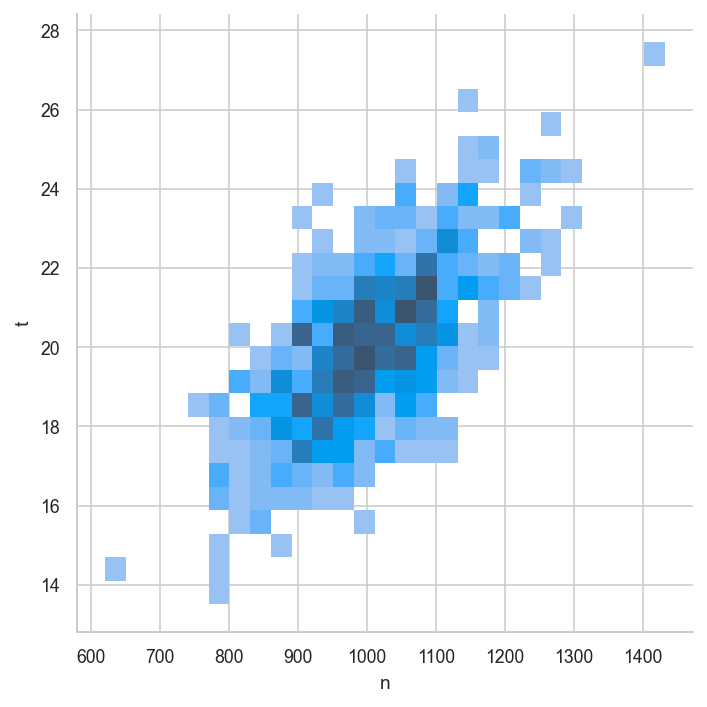

In [28]:
kprod = pd.DataFrame({"t":ts, "n":ns})
sns.displot(data=kprod, x="n", y="t")

In [29]:
# check data
# ns.shape
# kprod["t"]
# kprod["n"] # came from the numpy array `ns`

In [30]:
kprod["n"].std()

100.7280828876444

In [31]:
kprod["n"].mean()

1005.0907538677609

In [32]:
# # save data to kprod.csv
# kprod.to_csv("../datasets/kprod.csv")

In [33]:
kprod = pd.read_csv("../datasets/kprod.csv")
kprod

,Unnamed: 0,t,n
0,0,20.993428,995.565764
1,1,19.723471,1068.997191
2,2,21.295377,992.512421
3,3,23.046060,1000.977493
4,4,19.531693,866.862076
...,...,...,...
695,695,19.380907,992.182772
696,696,20.652266,921.794840
697,697,17.497773,839.550997
698,698,21.848054,1154.712934


In [34]:
kprod.describe()

,Unnamed: 0,t,n
count,700.00000,700.000000,700.000000
mean,349.50000,19.983708,1005.090754
std,202.21688,1.971220,100.728083
min,0.00000,13.517465,619.673850
25%,174.75000,18.610773,937.563085
50%,349.50000,19.997141,1002.065427
75%,524.25000,21.266132,1073.863544
max,699.00000,27.705463,1431.935309


## Plots inspired by seaborn docs


In [35]:
# penguins = sns.load_dataset("penguins")


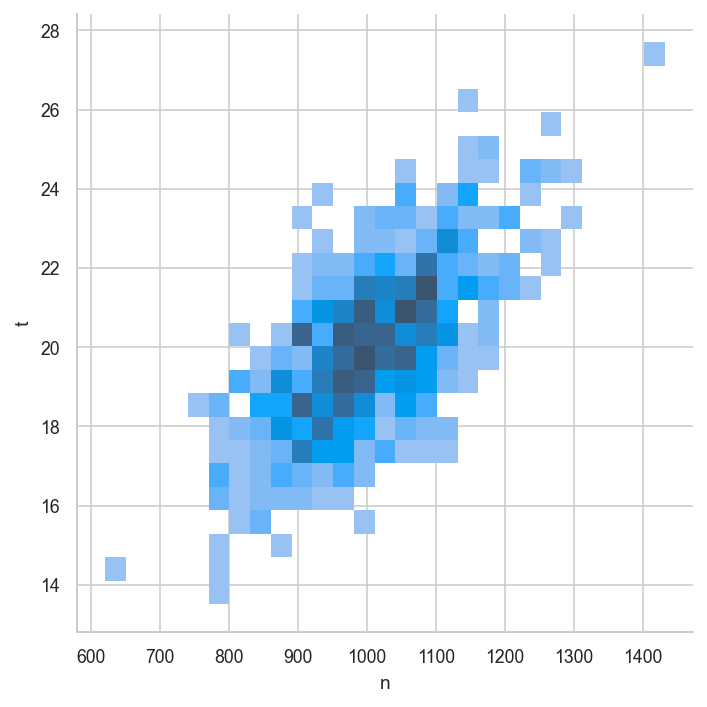

In [36]:
sns.displot(data=kprod, x="n", y="t")

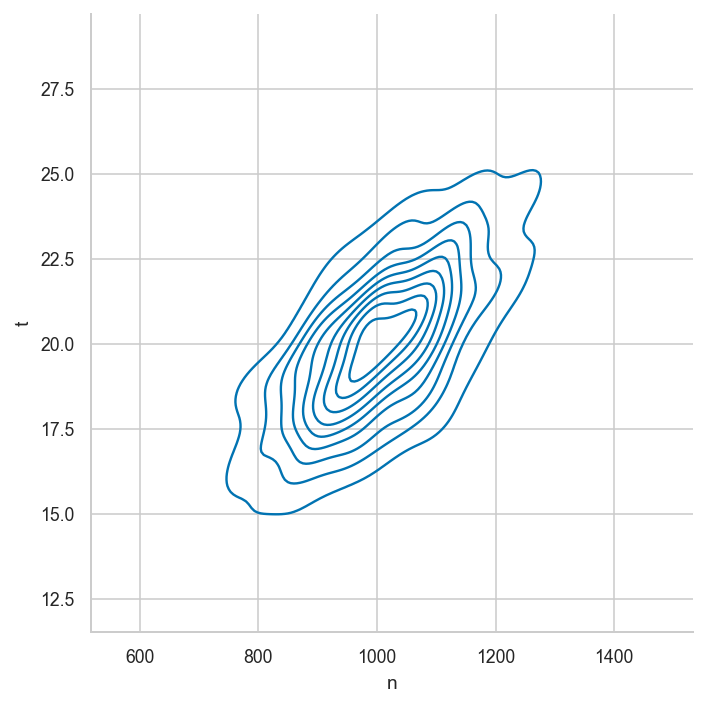

In [37]:
sns.displot(data=kprod, x="n", y="t", kind="kde")

In [38]:
# # ALT 1. fewer levels
# sns.displot(data=kprod, x="n", y="t", kind="kde", thresh=.2, levels=4)

In [39]:
# # ALT 2. specific levels
# sns.displot(data=kprod, x="n", y="t", kind="kde", levels=[.01, .05, .1, .8])

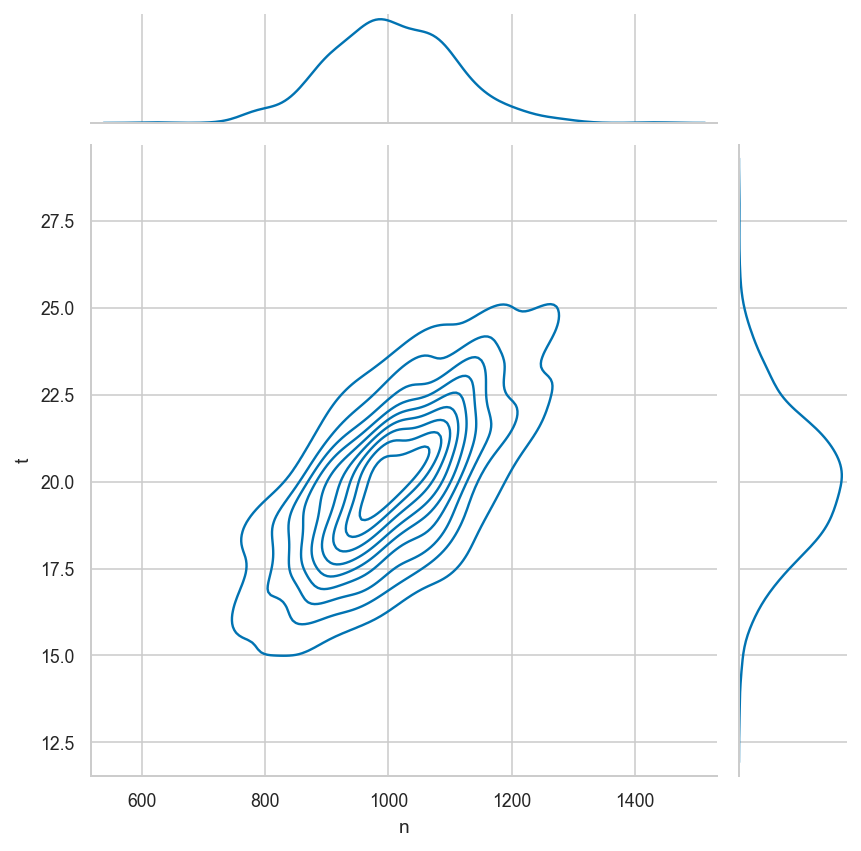

In [40]:
sns.jointplot(data=kprod, x="n", y="t", kind="kde")

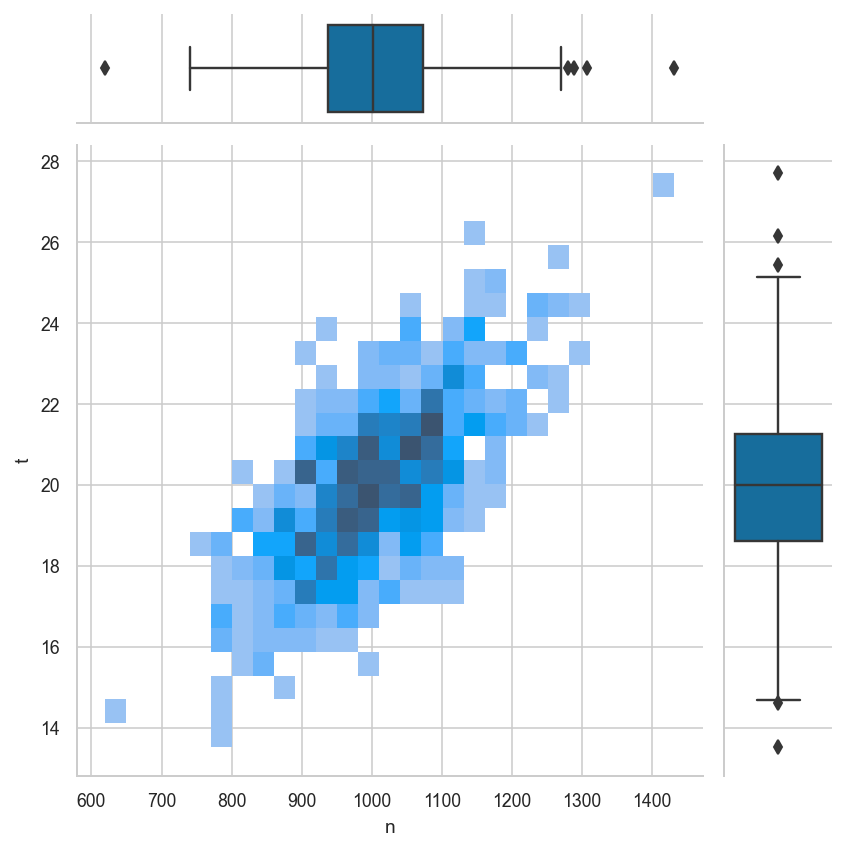

In [41]:
g = sns.JointGrid(data=kprod, x="n", y="t")
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)


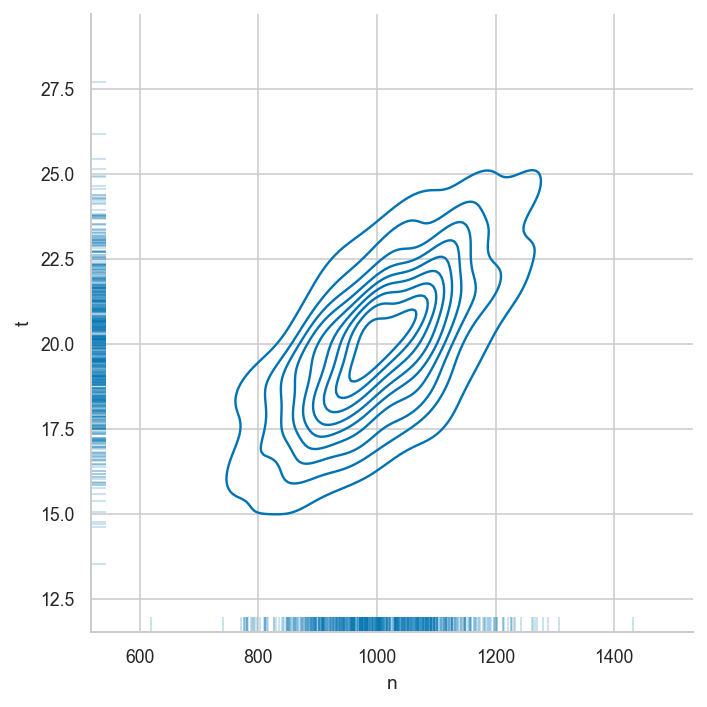

In [42]:
sns.displot(data=kprod, x="n", y="t", kind="kde",
            rug=True, rug_kws={"alpha":0.2})

## Other 3D and surface plot examples

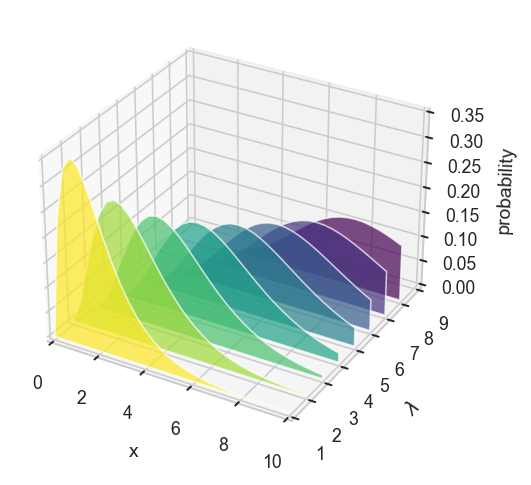

In [50]:
# via https://matplotlib.org/stable/gallery/mplot3d/polys3d.html

from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson

# Fixing random state for reproducibility
np.random.seed(19680801)


def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]


ax = plt.figure().add_subplot(projection='3d')

x = np.linspace(0., 10., 31)
lambdas = range(1, 9)

# verts[i] is a list of (x, y) pairs defining polygon i.
verts = [polygon_under_graph(x, poisson.pmf(l, x)) for l in lambdas]
facecolors = plt.colormaps['viridis_r'](np.linspace(0, 1, len(verts)))

poly = PolyCollection(verts, facecolors=facecolors, alpha=.7)
ax.add_collection3d(poly, zs=lambdas, zdir='y')

ax.set(xlim=(0, 10), ylim=(1, 9), zlim=(0, 0.35),
       xlabel='x', ylabel=r'$\lambda$', zlabel='probability')

plt.show()

In [51]:
# verts[0]

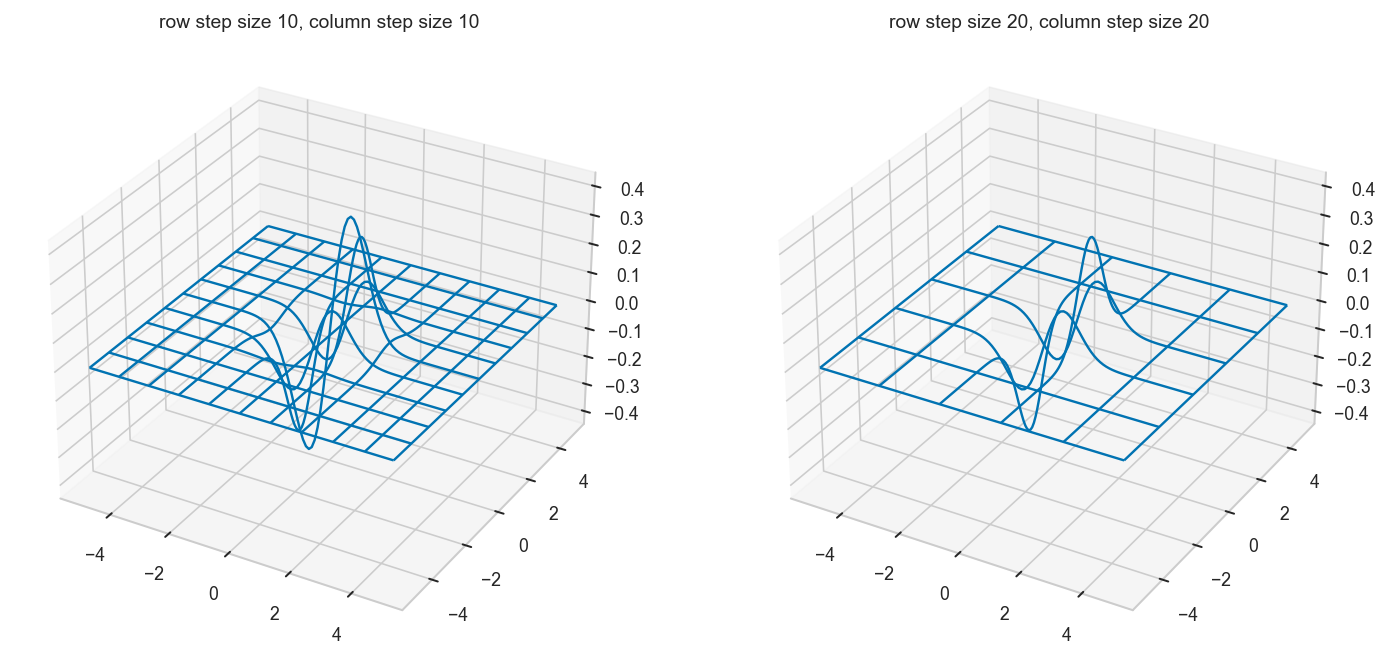

In [52]:
# via https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.16-3D-Surface-Plots/
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
# if using a Jupyter notebook, include:
%matplotlib inline




fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)
X,Y = np.meshgrid(x,y)
Z = X*np.exp(-X**2 - Y**2)

# Plot a basic wireframe
ax1.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax1.set_title('row step size 10, column step size 10')

ax2.plot_wireframe(X, Y, Z, rstride=20, cstride=20)
ax2.set_title('row step size 20, column step size 20')

plt.show()




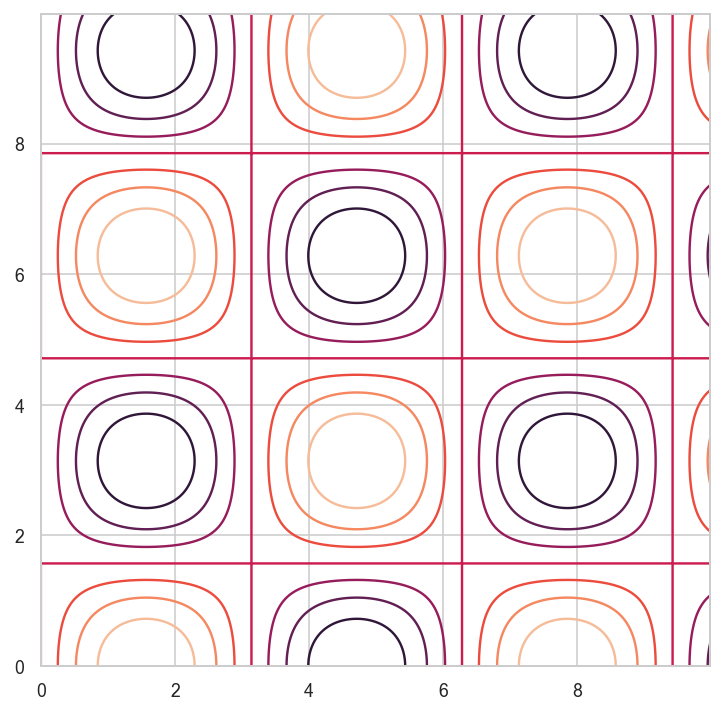

In [53]:
# via https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.14-Contour-Plots/

import numpy as np
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline


x = np.arange(0, 10.0, 0.01)
y = np.arange(0, 10.0, 0.01)

X, Y = np.meshgrid(x, y)

Z = np.sin(X)*np.cos(Y)

fig, ax = plt.subplots(figsize=(6,6))

# ax.contourf(X,Y,Z)
ax.contour(X,Y,Z)

plt.show()



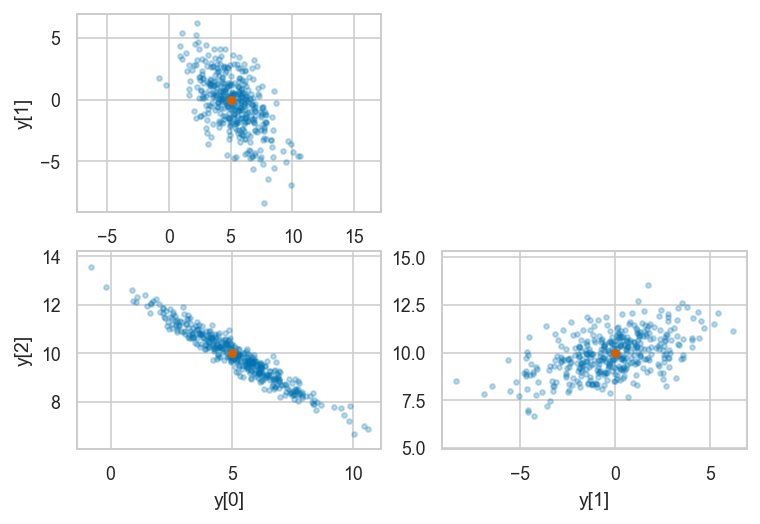

In [54]:
# via https://stackoverflow.com/questions/16024677/generate-correlated-data-in-python-3-3

import numpy as np
import matplotlib.pyplot as plt


num_samples = 400

# The desired mean values of the sample.
mu = np.array([5.0, 0.0, 10.0])

# The desired covariance matrix.
r = np.array([
        [  3.40, -2.75, -2.00],
        [ -2.75,  5.50,  1.50],
        [ -2.00,  1.50,  1.25]
    ])

# Generate the random samples.
rng = np.random.default_rng()
y = rng.multivariate_normal(mu, r, size=num_samples)


# Plot various projections of the samples.
plt.subplot(2,2,1)
plt.plot(y[:,0], y[:,1], 'b.', alpha=0.25)
plt.plot(mu[0], mu[1], 'ro', ms=3.5)
plt.ylabel('y[1]')
plt.axis('equal')
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(y[:,0], y[:,2], 'b.', alpha=0.25)
plt.plot(mu[0], mu[2], 'ro', ms=3.5)
plt.xlabel('y[0]')
plt.ylabel('y[2]')
plt.axis('equal')
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(y[:,1], y[:,2], 'b.', alpha=0.25)
plt.plot(mu[1], mu[2], 'ro', ms=3.5)
plt.xlabel('y[1]')
plt.axis('equal')
plt.grid(True)

plt.show()

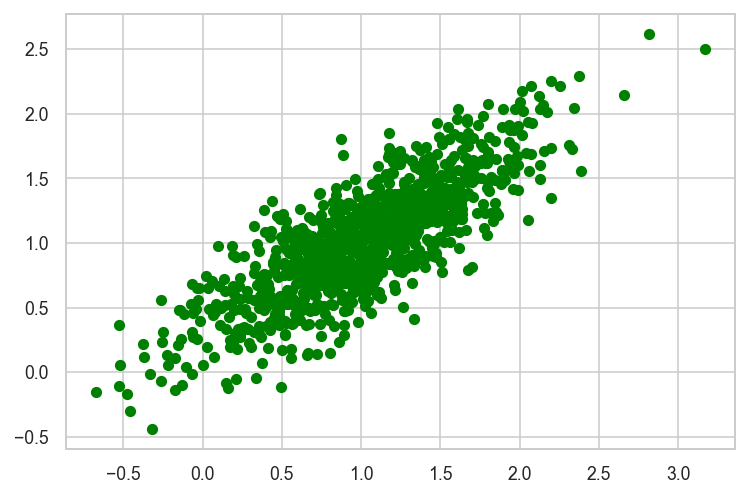

In [55]:
import numpy as np
import matplotlib.pyplot as plt
linalg = np.linalg
np.random.seed(1)

num_samples = 1000
num_variables = 2
cov = [[0.3, 0.2], [0.2, 0.2]]

L = linalg.cholesky(cov)
# print(L.shape)
# (2, 2)
uncorrelated = np.random.standard_normal((num_variables, num_samples))
mean = [1, 1]
correlated = np.dot(L, uncorrelated) + np.array(mean).reshape(2, 1)
# print(correlated.shape)
# (2, 1000)
plt.scatter(correlated[0, :], correlated[1, :], c='green')
plt.show()

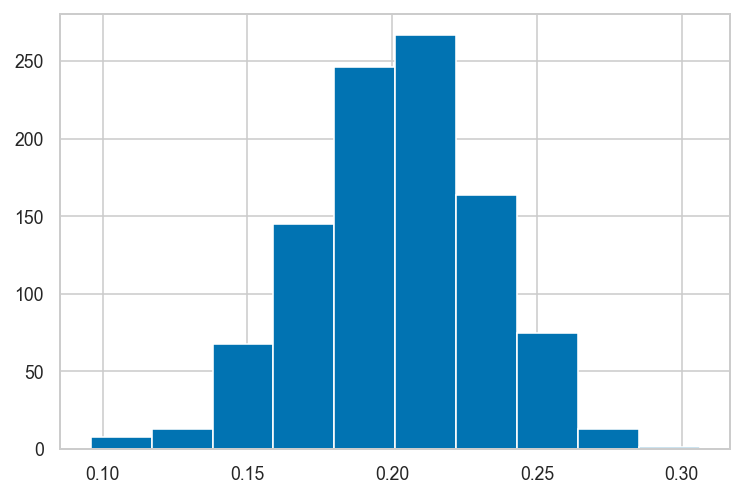

In [56]:
# via https://stackoverflow.com/questions/16024677/generate-correlated-data-in-python-3-3

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
linalg = np.linalg
np.random.seed(1)

num_samples = 1000
num_variables = 2
cov = [[1.0, 0.2], [0.2, 1.0]]

L = linalg.cholesky(cov)

rhos = []
for i in range(1000):
    uncorrelated = np.random.standard_normal((num_variables, num_samples))
    correlated = np.dot(L, uncorrelated)
    X, Y = correlated
    rho, pval = stats.pearsonr(X, Y)
    rhos.append(rho)

plt.hist(rhos)
plt.show()

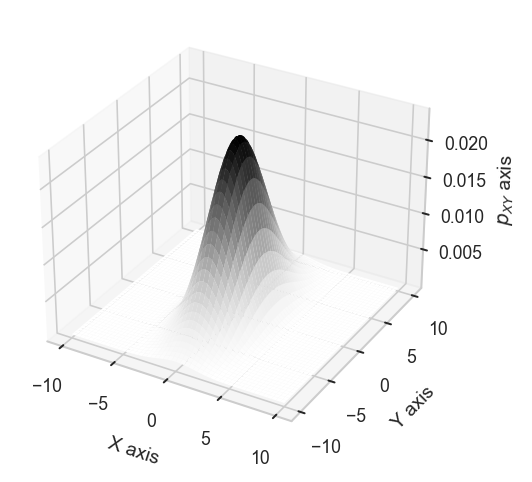

In [57]:
# via https://stackoverflow.com/questions/38698277/plot-normal-distribution-in-3d
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

#Parameters to set
mu_x = 0
variance_x = 3

mu_y = 0
variance_y = 15

#Create grid and multivariate normal
x = np.linspace(-10,10,500)
y = np.linspace(-10,10,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
rv = multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])

#Make a 3D plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos), cmap='Greys', linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('$p_{XY}$ axis')
plt.show()


In [58]:
pos.shape

(500, 500, 2)

In [59]:
rv.pdf(pos).shape

(500, 500)

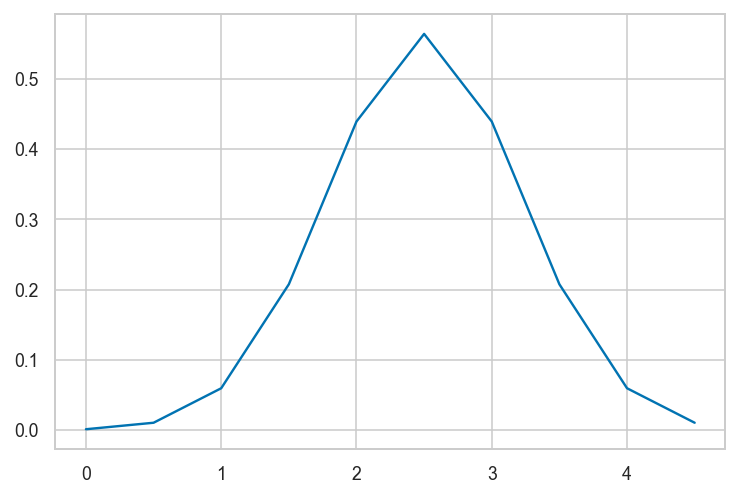

In [60]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html#scipy.stats.multivariate_normal

from scipy.stats import multivariate_normal

x = np.linspace(0, 5, 10, endpoint=False)

y = multivariate_normal.pdf(x, mean=2.5, cov=0.5)

fig1 = plt.figure()

ax = fig1.add_subplot(111)

ax.plot(x, y)

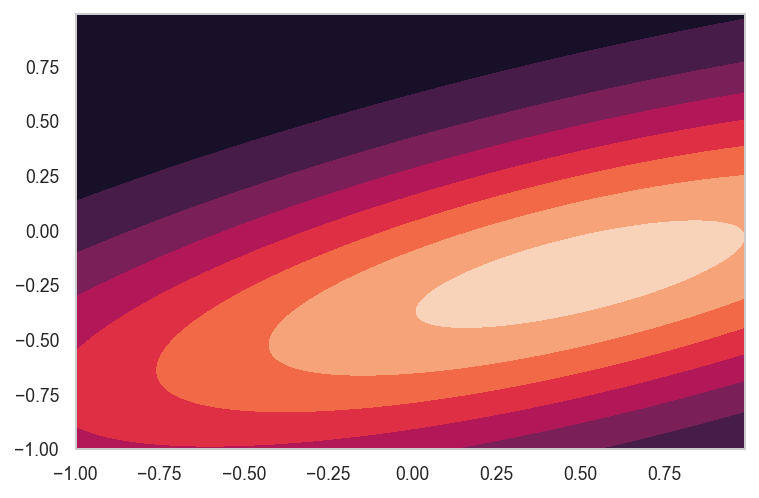

In [61]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]

pos = np.dstack((x, y))

mu = [0.5, -0.2]
Sigma = [[2.0, 0.7], [0.7, 0.5]]
rv = multivariate_normal(mu, Sigma)


fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))

In [62]:
rv.pdf(pos)

array([[0.10948266, 0.11064805, 0.11178199, ..., 0.00045415, 0.00042486,
        0.0003973 ],
       [0.10988591, 0.11107083, 0.11222452, ..., 0.00046831, 0.00043817,
        0.00040981],
       [0.11027983, 0.11148431, 0.11265774, ..., 0.00048287, 0.00045186,
        0.00042267],
       ...,
       [0.03403147, 0.03533639, 0.03667695, ..., 0.02904694, 0.02791839,
        0.02682317],
       [0.03350345, 0.0347929 , 0.0361178 , ..., 0.02938003, 0.02824242,
        0.02713821],
       [0.03298039, 0.03425441, 0.03556368, ..., 0.02971402, 0.0285674 ,
        0.02745425]])

<AxesSubplot:>

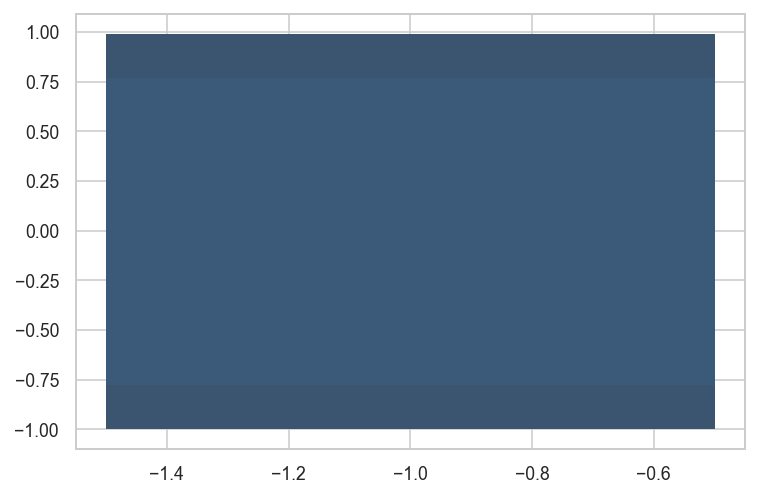

In [63]:
sns.histplot(x=x[0], y=y[0])

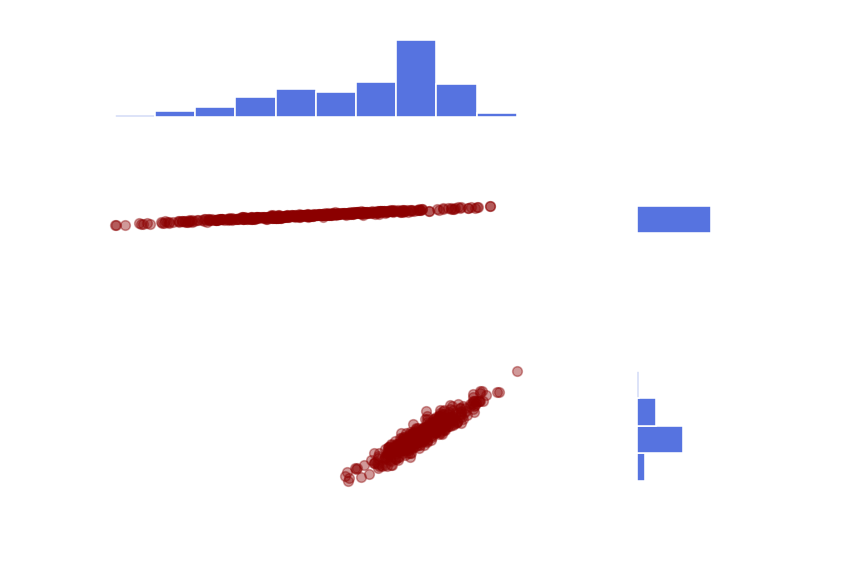

In [64]:
# via http://cxhernandez.com/tutorials/dataviz/2014/11/19/jointplot-d3.html

from matplotlib import pyplot as plt
from matplotlib import gridspec


def gen_cov(n):
    A = np.random.rand(n, n)
    return np.dot(A, A.T)


n = 2
m = 2
mu = list(map(lambda x: np.random.normal(size = x)*np.random.randint(1,11) + np.random.normal(size = x), n*[m]))
sigma = list(map(gen_cov, n*[m]))

N = 500
data = np.vstack(
    list(
        map(
            lambda i: np.random.multivariate_normal(mu[i], sigma[i], N),
            range(n)
           )
         )
).T


xmin, ymin = data.min(axis=1)
xmax, ymax = data.max(axis=1)

xmax, xmin = tuple(np.array([xmax, xmin]) + 0.25*(xmax - xmin)*np.array([1, -1]))
ymax, ymin = tuple(np.array([ymax, ymin]) + 0.25*(ymax - ymin)*np.array([1, -1]))



#Define grid for subplots
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios = [1, 4])

#Create scatter plot
fig = plt.figure()
ax = plt.subplot(gs[1, 0])
cax = ax.scatter(data[0], data[1], color='darkred', alpha=.4)

#Turn off all axes
_=ax.axis('off')

#Create Y-marginal (right)
axr = plt.subplot(gs[1, 1], sharey=ax, xticks=[], yticks=[],frameon = False, xlim=(0, 1), ylim = (ymin, ymax))
axr.hist(data[1], color = '#5673E0', orientation = 'horizontal', density = True)

#Create X-marginal (top)
axt = plt.subplot(gs[0,0], sharex=ax,frameon = False, xticks = [], yticks = [], xlim = (xmin, xmax), ylim=(0, 1))
axt.hist(data[0], color = '#5673E0', density = True)

#Bring the marginals closer to the scatter plot
fig.tight_layout(pad = 1)

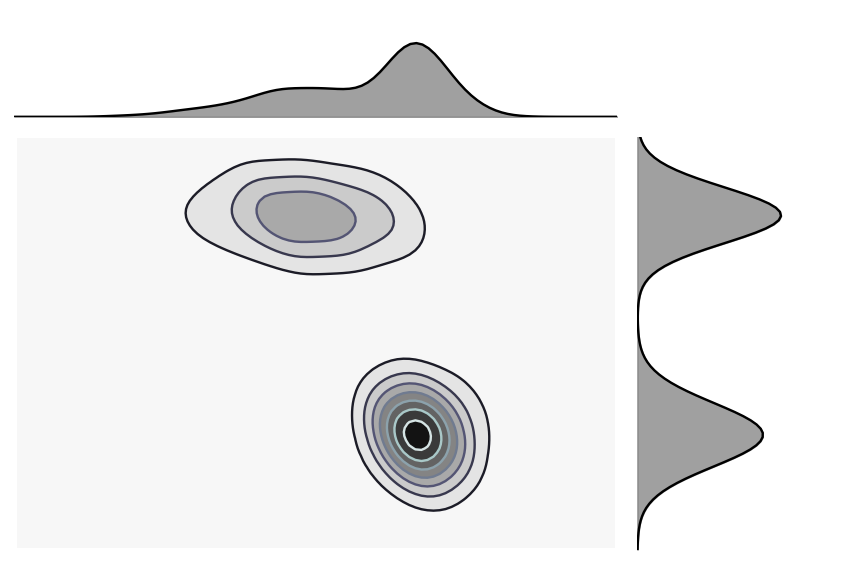

In [65]:
from matplotlib import cm
from scipy.stats import gaussian_kde


#KDE for top marginal
kde_X = gaussian_kde(data[0])
#KDE for right marginal
kde_Y = gaussian_kde(data[1])
#KDE for contour plot
kde_XY = gaussian_kde(data)

# Create two 1D grid with 100 points in each dimension
x = np.linspace(xmin, xmax, 100)
y = np.linspace(ymin, ymax, 100)

# Create a regular 2D grid with 100 points in each dimension
xi, yi = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
coords = np.vstack([item.ravel() for item in [xi, yi]])

# Evaluate the KDEs on a 1D grid
dx = kde_X(x) # X-marginal density
dy = kde_Y(y) # Y-marginal density

# Evaluate the KDE on a 2D grid
density = kde_XY(coords).reshape(xi.shape) # Bivariate density


#Set style to white
sns.set_style('white')

#Define grid for subplots
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 4])

#Create contour plot
fig = plt.figure()
ax = plt.subplot(gs[1,0])
# Filled Contour
cax = ax.contourf(density.T, origin = 'lower',
                  extent = (xmin, xmax, ymin, ymax),
                  cmap = "Greys") #coolwarm)
# Contour Lines
ax.contour(density.T, origin = 'lower',
           extent = (xmin, xmax, ymin, ymax),
           cmap = cm.bone)

# cbar = fig.colorbar(cax, location="bottom", panchor=(0,0), pad=0)

#Turn off all axes
ax.axis('off')

#Create Y-marginal (right)
axr = plt.subplot(gs[1,1], sharey = ax, xticks = [], yticks = [], frameon = False, xlim = (0, 1.4*dy.max()), ylim=(ymin, ymax))
axr.plot(dy, y, color = 'black')
axr.fill_betweenx(y, 0, dy, alpha = .75, color = 'gray')

#Create X-marginal (top)
axt = plt.subplot(gs[0,0], sharex = ax, frameon = False, xticks=[], yticks=[], xlim = (xmin, xmax), ylim=(0, 1.4*dx.max()))
axt.plot(x, dx, color = 'black')
axt.fill_between(x, 0, dx, alpha=.75, color = 'gray')

#Bring the marginals closer to the contour plot
fig.tight_layout(pad = 1)



### Coin tosses for n=100, n=1000, and n=10000

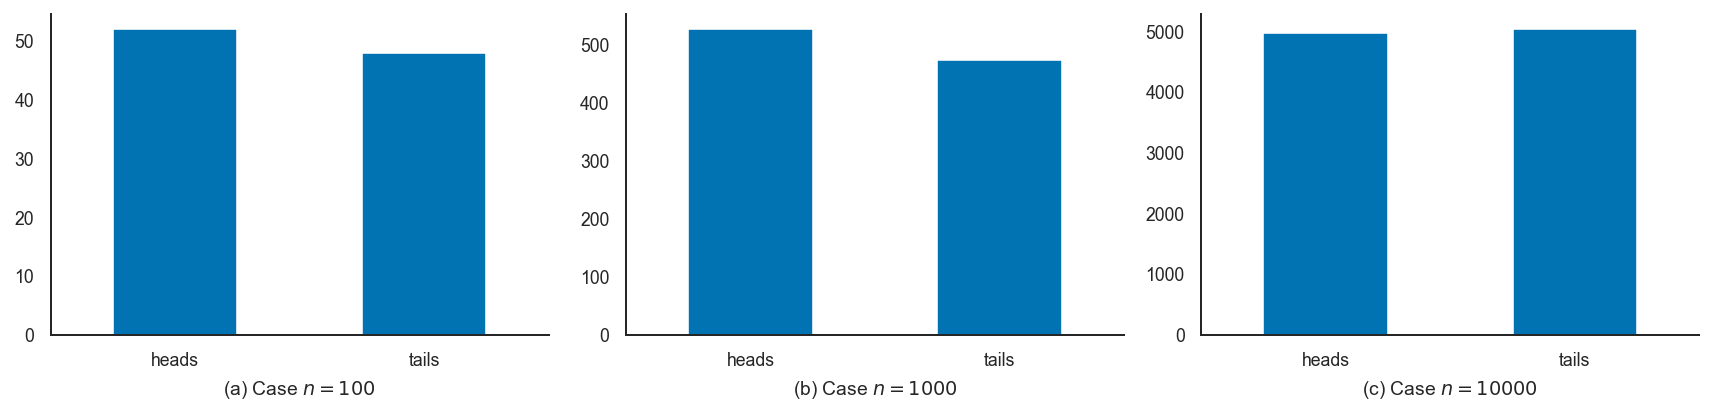

In [66]:
import numpy as np
np.random.seed(15)

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint

rvC = randint(0, 2)


filename = "figures/panel_n_coin_flips.pdf"


with plt.rc_context({"figure.figsize":(12,3)}):
    fig, axs = plt.subplots(1, 3)
    ax1, ax2, ax3 = axs

    n = 100
    flips = rvC.rvs(n)
    s = pd.Series(flips).replace(1, "heads").replace(0, "tails")
    # print(f"Case {n=}")
    # print(s.value_counts().sort_index())
    s.value_counts().sort_index().plot(kind="bar", rot=0, ax=ax1)
    title1 = f"(a) Case $n={n}$"
    ax1.set_title(title1, y=0, pad=-30)
    sns.despine(top=True, right=True, ax=ax1)

    n = 1000
    flips = rvC.rvs(n)
    s = pd.Series(flips).replace(1, "heads").replace(0, "tails")
    # print(f"Case {n=}")
    # print(s.value_counts().sort_index())
    s.value_counts().sort_index().plot(kind="bar", rot=0, ax=ax2)
    title2 = f"(b) Case $n={n}$"
    ax2.set_title(title2, y=0, pad=-30)
    sns.despine(top=True, right=True, ax=ax2)

    n = 10000
    flips = rvC.rvs(n)
    s = pd.Series(flips).replace(1, "heads").replace(0, "tails")
    # print(f"Case {n=}")
    # print(s.value_counts().sort_index())
    s.value_counts().sort_index().plot(kind="bar", rot=0, ax=ax3)
    title3 = f"(c) Case $n={n}$"
    ax3.set_title(title3, y=0, pad=-30)
    sns.despine(top=True, right=True, ax=ax3)
    
    fig.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)


### Dice rolls 600 6000 60000

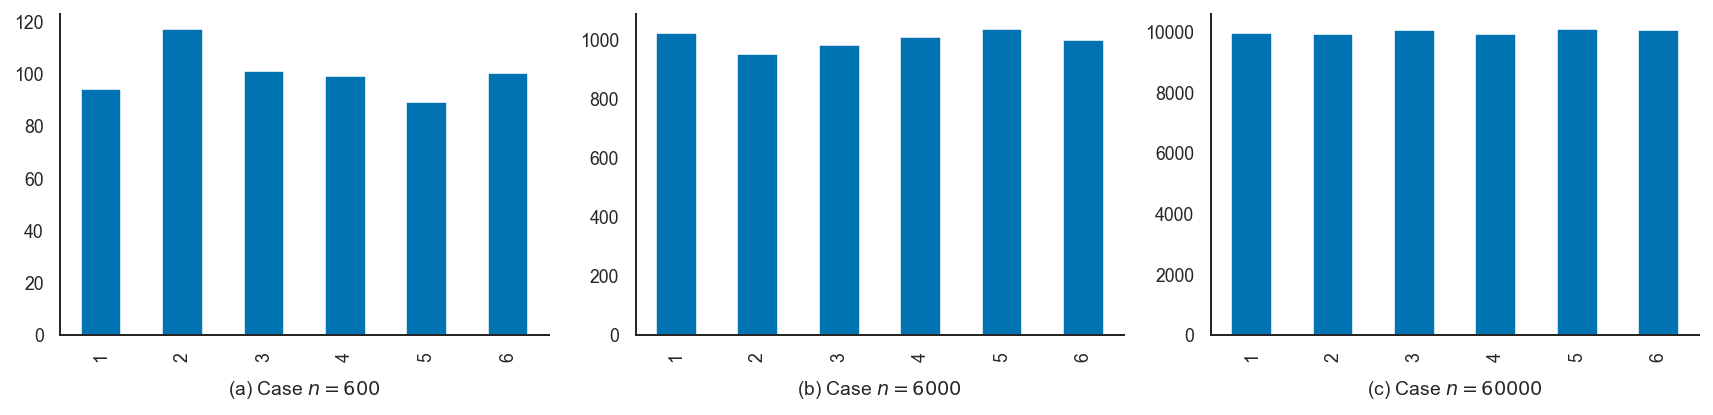

In [67]:
import numpy as np
np.random.seed(5)

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint

rvD = randint(1, 7)


filename = "figures/panel_n_dice_rolls.pdf"


with plt.rc_context({"figure.figsize":(12,3)}):
    fig, axs = plt.subplots(1, 3)
    ax1, ax2, ax3 = axs

    n = 600
    rolls = rvD.rvs(n)
    ds = pd.Series(rolls)
    # print(f"Case {n=}")
    # print(ds.value_counts().sort_index())
    ds.value_counts().sort_index().plot(kind="bar", ax=ax1)
    title1 = f"(a) Case $n={n}$"
    ax1.set_title(title1, y=0, pad=-30)
    sns.despine(top=True, right=True, ax=ax1)

    n = 6000
    rolls = rvD.rvs(n)
    ds = pd.Series(rolls)
    # print(f"Case {n=}")
    # print(ds.value_counts().sort_index())
    ds.value_counts().sort_index().plot(kind="bar", ax=ax2)
    title2 = f"(b) Case $n={n}$"
    ax2.set_title(title2, y=0, pad=-30)
    sns.despine(top=True, right=True, ax=ax2)

    n = 60000
    rolls = rvD.rvs(n)
    ds = pd.Series(rolls)
    # print(f"Case {n=}")
    # print(ds.value_counts().sort_index())
    ds.value_counts().sort_index().plot(kind="bar", ax=ax3)
    title3 = f"(c) Case $n={n}$"
    ax3.set_title(title3, y=0, pad=-30)
    sns.despine(top=True, right=True, ax=ax3)

    fig.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)


### POC using X^2 + Y^2

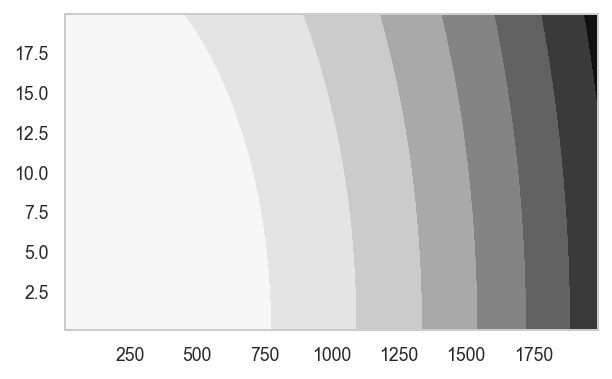

In [ ]:
from matplotlib import gridspec

xmin = 0
xmax = 2000
ymin = 0
ymax = 20

# Create two 1D grid with 100 points in each dimension
x = np.linspace(xmin, xmax, 100)
y = np.linspace(ymin, ymax, 100)

X, Y = np.meshgrid(x,y)


Z = X**2 + 1000*Y**2

#Create contour plot
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 4])
fig = plt.figure()
ax = plt.subplot(gs[1,0])
# Filled Contour
cax = ax.contourf(Z, origin = 'lower',
                  extent = (xmin, xmax, ymin, ymax),
                  cmap = "Greys")


In [9]:
# # ALT1: generate N data points using rvs(N)
# N = 10000
# dfXY = pd.DataFrame(rvXY.rvs(N), columns=["x","y"])

# # controur plot
# sns.jointplot(data=dfXY, x="x", y="y",
#               kind="kde")

# # countourf plot
# sns.kdeplot(data=dfXY, x="x", y="y",
#             shade=True, shade_lowest=False)

In [10]:
a = np.array((1,2,3))
b = np.array((2,3,4))
np.dstack((a,b))
np.dstack((a,b)).shape

(1, 3, 2)

In [11]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]

pos = np.dstack((x, y))
pos.shape

(200, 200, 2)

In [12]:
# evaluate for a point (x,y)
rvXY.pdf((1000,10))

0.0006784909393334893

In [13]:
# evaluate for a list of points (x,y)
XY = np.array(
    [
     [1000, 10],
     [1010, 11],
     [ 995,  9],
    ]
)

XY

rvXY.pdf(XY)

array([0.00067849, 0.00049852, 0.00048538])

In [81]:
# evaluate over an meshgrid of points
xmin = 0
xmax = 2000
ymin = 0
ymax = 20
xs = np.linspace(xmin, xmax, 5)
ys = np.linspace(ymin, ymax, 3)
X, Y = np.meshgrid(xs, ys)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

print("pos.shape", pos.shape)


pos.shape (3, 5, 2)


In [82]:
# pos
# print("rvXY.pdf(pos).shape", rvXY.pdf(pos).shape)
# rvXY.pdf(pos)

### Coin tosses for n=100, n=1000, and n=10000

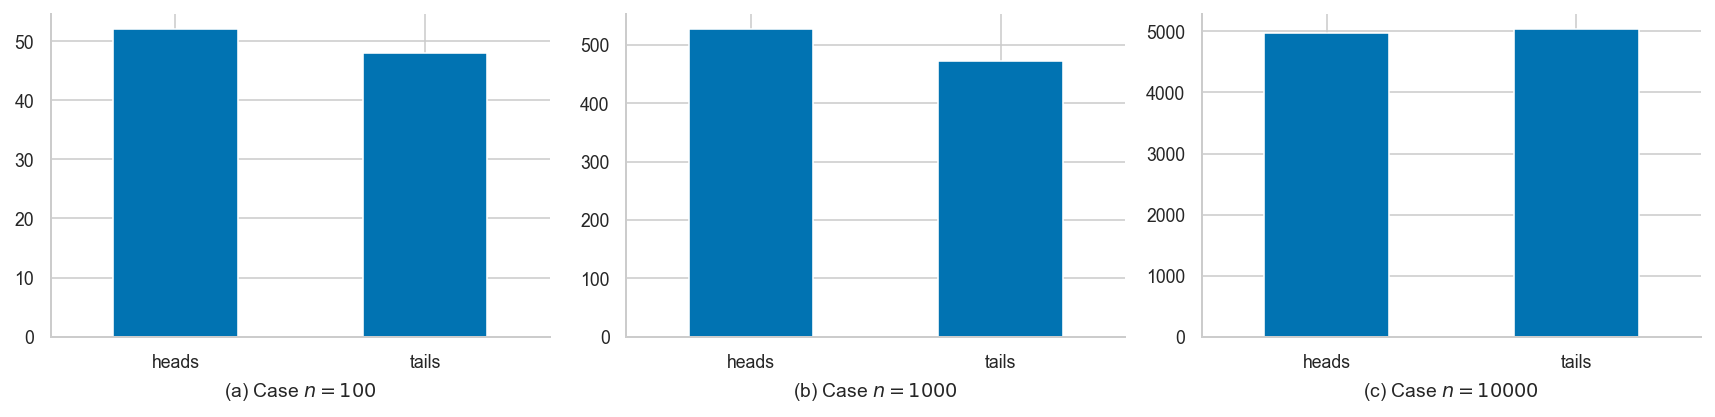

In [20]:
import numpy as np
np.random.seed(15)

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint

rvC = randint(0, 2)


filename = "figures/panel_n_coin_flips.pdf"


with plt.rc_context({"figure.figsize":(12,3)}):
    fig, axs = plt.subplots(1, 3)
    ax1, ax2, ax3 = axs

    n = 100
    flips = rvC.rvs(n)
    s = pd.Series(flips).replace(1, "heads").replace(0, "tails")
    # print(f"Case {n=}")
    # print(s.value_counts().sort_index())
    s.value_counts().sort_index().plot(kind="bar", rot=0, ax=ax1)
    title1 = f"(a) Case $n={n}$"
    ax1.set_title(title1, y=0, pad=-30)
    sns.despine(top=True, right=True, ax=ax1)

    n = 1000
    flips = rvC.rvs(n)
    s = pd.Series(flips).replace(1, "heads").replace(0, "tails")
    # print(f"Case {n=}")
    # print(s.value_counts().sort_index())
    s.value_counts().sort_index().plot(kind="bar", rot=0, ax=ax2)
    title2 = f"(b) Case $n={n}$"
    ax2.set_title(title2, y=0, pad=-30)
    sns.despine(top=True, right=True, ax=ax2)

    n = 10000
    flips = rvC.rvs(n)
    s = pd.Series(flips).replace(1, "heads").replace(0, "tails")
    # print(f"Case {n=}")
    # print(s.value_counts().sort_index())
    s.value_counts().sort_index().plot(kind="bar", rot=0, ax=ax3)
    title3 = f"(c) Case $n={n}$"
    ax3.set_title(title3, y=0, pad=-30)
    sns.despine(top=True, right=True, ax=ax3)
    
    fig.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)


### Dice rolls 600 6000 60000

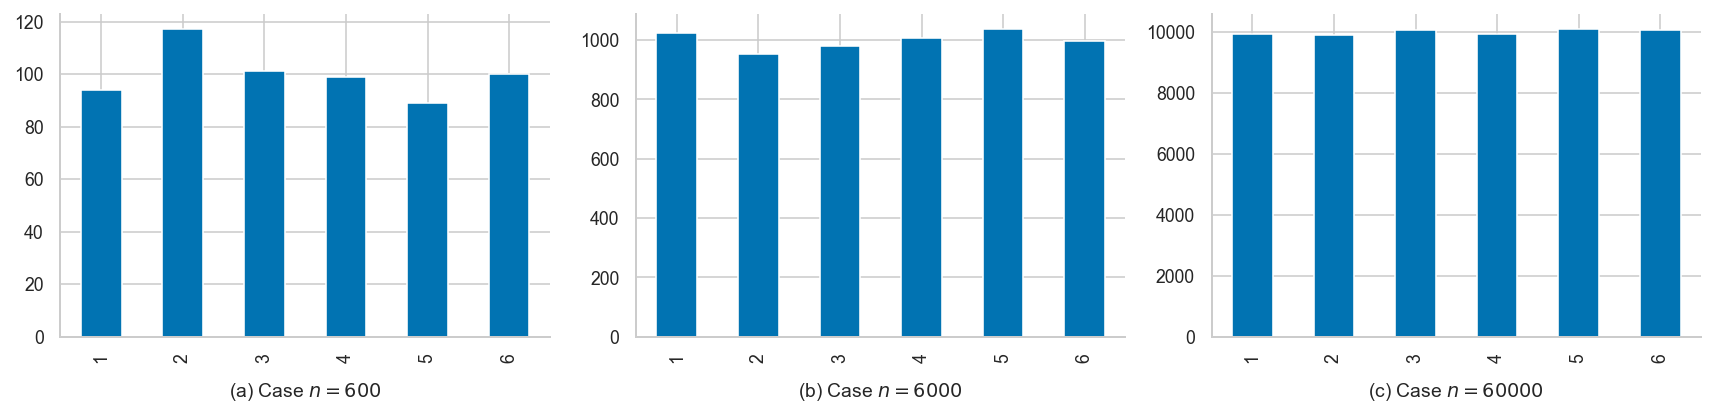

In [21]:
import numpy as np
np.random.seed(5)

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint

rvD = randint(1, 7)


filename = "figures/panel_n_dice_rolls.pdf"


with plt.rc_context({"figure.figsize":(12,3)}):
    fig, axs = plt.subplots(1, 3)
    ax1, ax2, ax3 = axs

    n = 600
    rolls = rvD.rvs(n)
    ds = pd.Series(rolls)
    # print(f"Case {n=}")
    # print(ds.value_counts().sort_index())
    ds.value_counts().sort_index().plot(kind="bar", ax=ax1)
    title1 = f"(a) Case $n={n}$"
    ax1.set_title(title1, y=0, pad=-30)
    sns.despine(top=True, right=True, ax=ax1)

    n = 6000
    rolls = rvD.rvs(n)
    ds = pd.Series(rolls)
    # print(f"Case {n=}")
    # print(ds.value_counts().sort_index())
    ds.value_counts().sort_index().plot(kind="bar", ax=ax2)
    title2 = f"(b) Case $n={n}$"
    ax2.set_title(title2, y=0, pad=-30)
    sns.despine(top=True, right=True, ax=ax2)

    n = 60000
    rolls = rvD.rvs(n)
    ds = pd.Series(rolls)
    # print(f"Case {n=}")
    # print(ds.value_counts().sort_index())
    ds.value_counts().sort_index().plot(kind="bar", ax=ax3)
    title3 = f"(c) Case $n={n}$"
    ax3.set_title(title3, y=0, pad=-30)
    sns.despine(top=True, right=True, ax=ax3)

    fig.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)
